In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
import arviz as az
from astropy.cosmology import Planck18
import astropy.units as u
import sys
sys.path.append('../src/')
import intensity_models
import jax
import numpy as np
from numpyro.infer import MCMC, NUTS, SA
import os.path as op
import pandas as pd
import paths
import cloudpickle

from utils import get_priors_from_file
from importlib import reload
import corner
from tqdm import tqdm

import seaborn as sns
from intensity_models import coords
import scipy.stats as ss
import xarray as xr
from scipy.special import logsumexp


from importlib import reload
reload(intensity_models)

/mnt/home/amoran/miniforge3/envs/GW_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'intensity_models' from '/mnt/home/amoran/GW_stuff/reproduce/../src/intensity_models.py'>

In [5]:
import gc
gc.collect()

166

In [6]:
nsamp = 200  # number of posterior draws per event
prior = get_priors_from_file("priors/gwtc3_evolution.prior")

pe_samples = pd.read_hdf('../src/data/mock_observations.h5', 'observations')
pe_samples['pdraw_cosmo'] = pe_samples['pdraw_mqz'] * pe_samples['dm1sz_dm1ddl']

sel_samples = pd.read_hdf('../src/mock_injections.h5', 'true_parameters')
sel_samples['pdraw_cosmo'] = sel_samples['pdraw_mqz'] * sel_samples['dm1sz_dm1ddl']
sel_samples['m1d'] = sel_samples['m1']*(1+sel_samples['z'])
sel_samples['dl'] = Planck18.luminosity_distance(sel_samples['z'].to_numpy()).to(u.Gpc).value

In [7]:
def process_samples(data_file):
    posterior_dict = {}

    for param in data_file.files:
        arr = data_file[param]
        shape = arr.shape
    
        if len(shape) == 2:
            # Standard MCMC shape: (chain, draw)
            dims = ("chain", "draw")
        elif len(shape) == 3:
            # Extra dimension (e.g., shape parameters): assign a third dimension
            dims = ("chain", "draw", f"{param}_dim")
        else:
            raise ValueError(f"Unsupported shape {shape} for variable {param}")
    
        posterior_dict[param] = (dims, arr)
    mbhmax = data_file['dmbhmax'] + data_file['mpisn']
    
    # Now build coordinates based on one of the variables
    example_shape = data_file[data_file.files[0]].shape
    shapes = {
        "chain": np.arange(example_shape[0]),
        "draw": np.arange(example_shape[1])
    }
    # Add extra dims if needed
    for param in data.files:
        if data_file[param].ndim == 3:
            shapes[f"{param}_dim"] = np.arange(data_file[param].shape[2])
    
    # Build dataset and convert to InferenceData
    posterior = xr.Dataset(posterior_dict, coords=shapes)
    idata = az.InferenceData(posterior=posterior)
    idata.posterior["mbhmax"] = (("chain", "draw"), mbhmax)
    idata.add_groups({"log_likelihood": {"loglik_array_dim": data_file['loglik_array_dim']}})
    return idata

In [8]:
data = np.load("mock_obs_1det_gc.npz")
print(data.files)
gc_818=process_samples(data)

['Om', 'R', 'R_unit', 'a', 'b', 'beta', 'c', 'dNdVdt_fixed_mq', 'dNdqdVdt_fixed_mz', 'delta_m', 'dkappa', 'dmbhmax', 'h', 'hz', 'lam', 'log_fpl', 'loglik_array_dim', 'mbh_min', 'mdNdmdVdt_fixed_qz', 'mpisn', 'mpisndot', 'neff', 'neff_sel', 'sigma', 'w', 'zmax', 'zp']


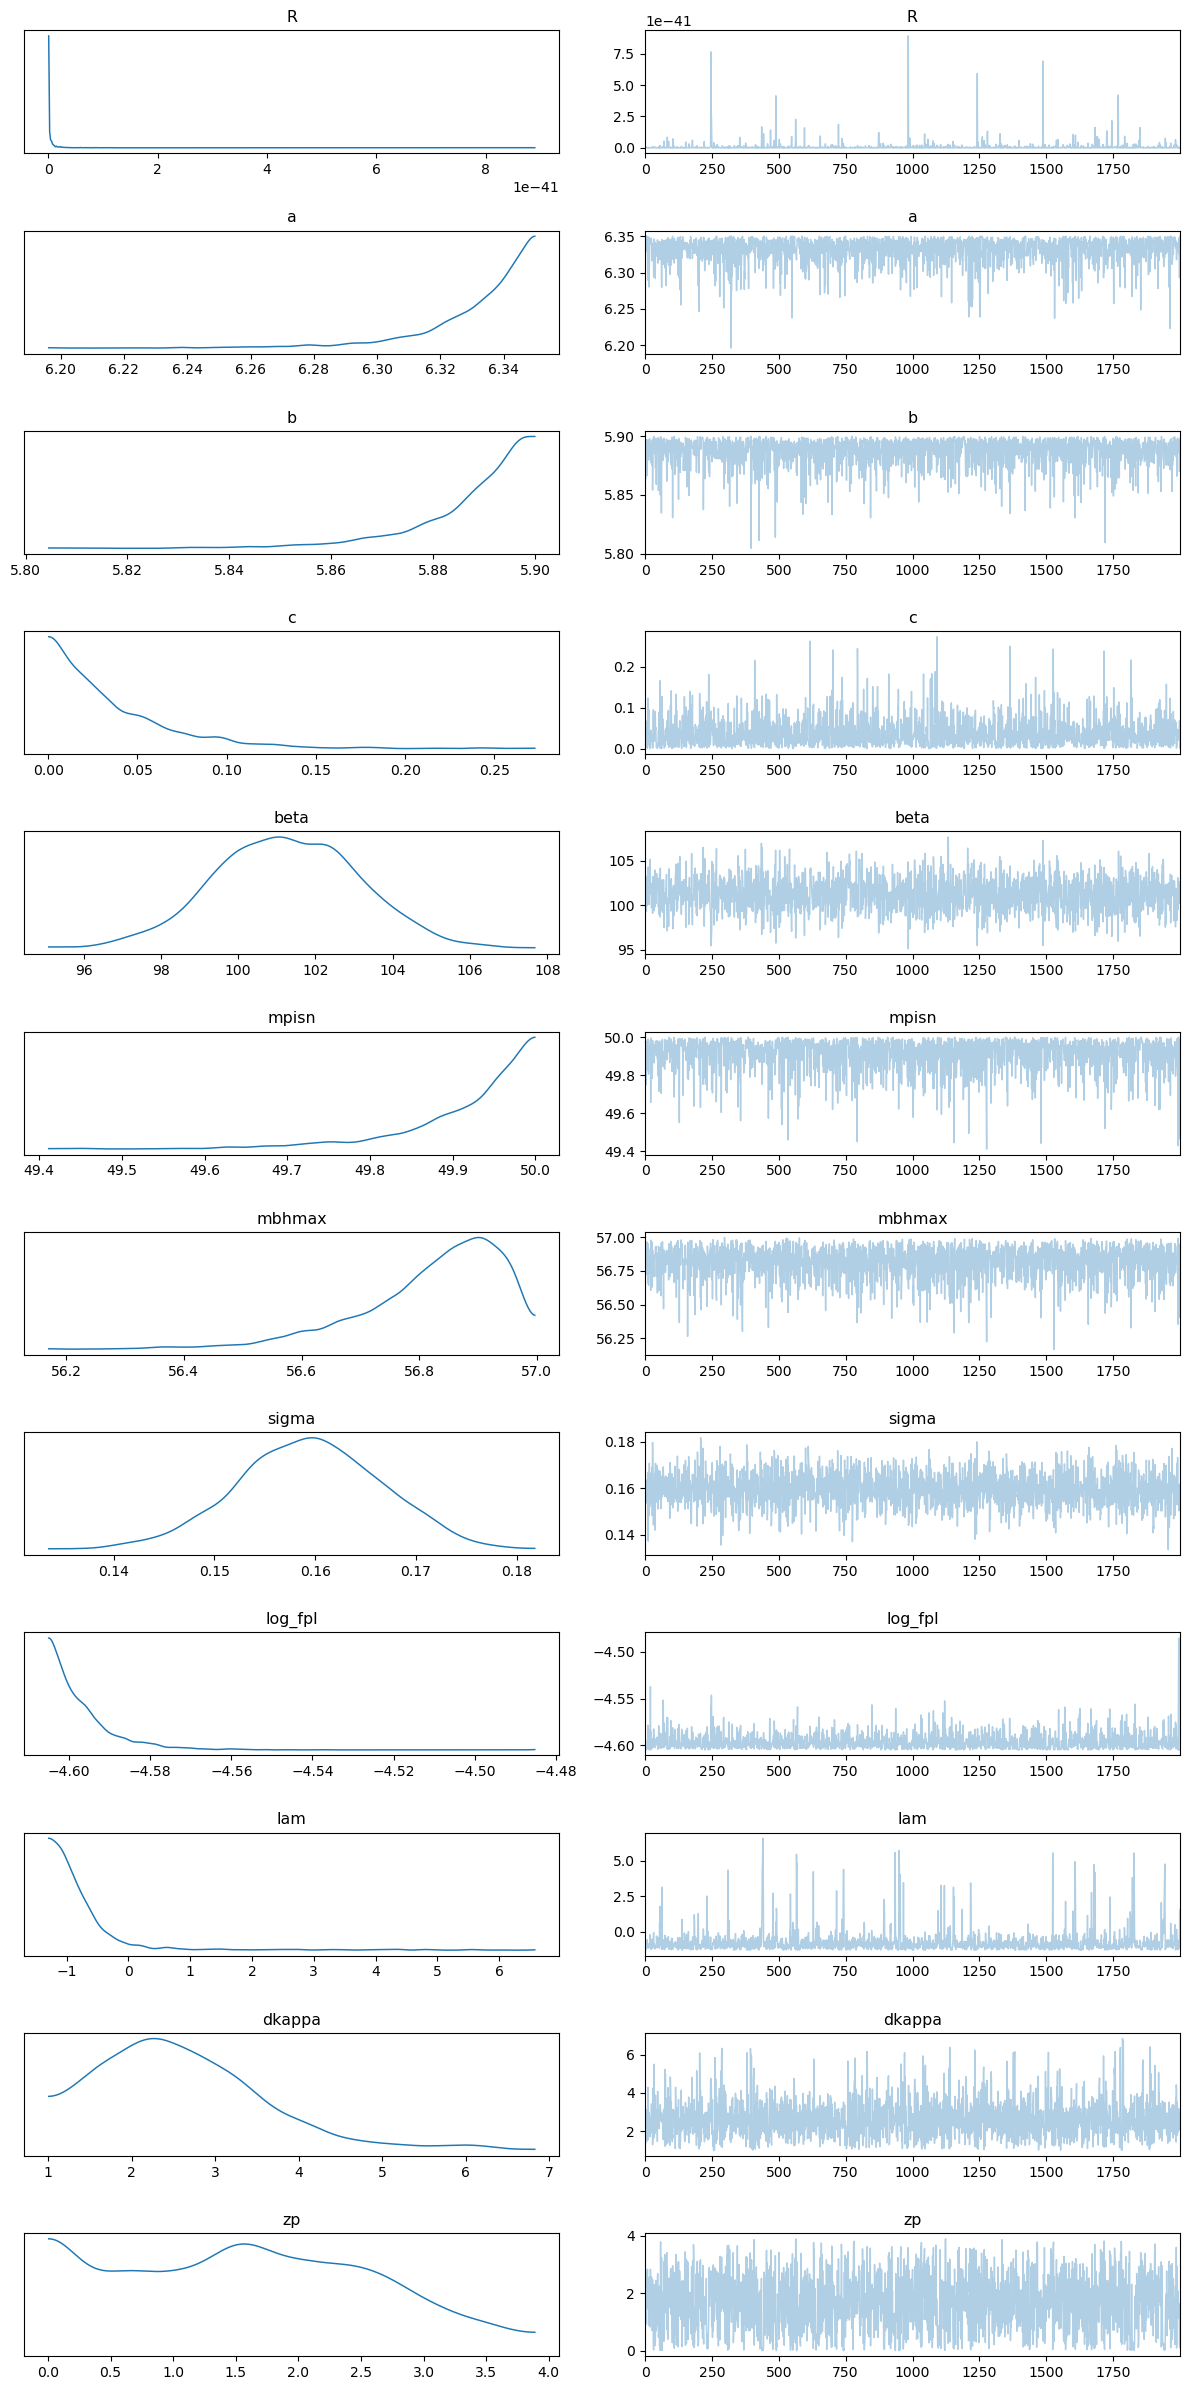

In [9]:
az.plot_trace(gc_818, var_names=['R', 'a', 'b', 'c', 'beta', 'mpisn', 'mbhmax', 'sigma', 'log_fpl', 'lam', 'dkappa', 'zp']);
plt.tight_layout()


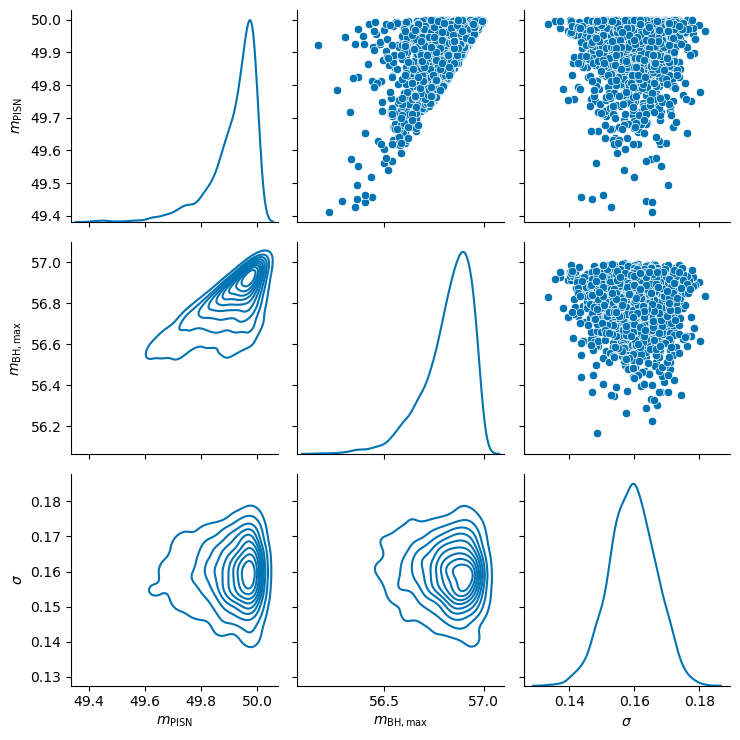

In [10]:
sns.set_palette('colorblind')
#trace = az.from_netcdf(op.join(paths.data, 'trace.nc'))

axes_labels = {
    'mpisn': r'$m_\mathrm{PISN}$',
    'mbhmax': r'$m_\mathrm{BH,max}$',
    'sigma': r'$\sigma$'
}
df = pd.DataFrame({axes_labels[k]: gc_818.posterior[k].values.flatten() for k in axes_labels.keys()})

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

plt.tight_layout()
#plt.savefig(op.join(paths.figures, 'shape_corner.pdf'))

/mnt/home/amoran/miniforge3/envs/GW_py310/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'mpisndot'}>,
        <Axes: title={'center': 'mpisndot'}>]], dtype=object)

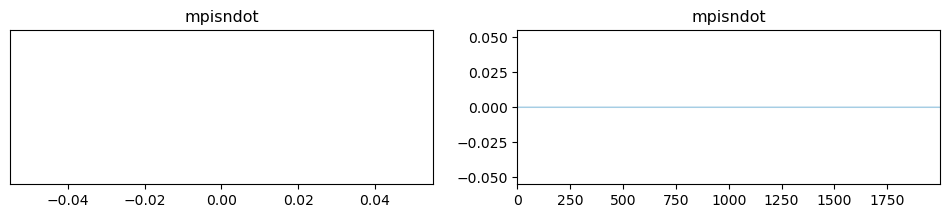

In [32]:
az.plot_trace(gc_818, var_names=['mpisndot'])

/mnt/home/amoran/miniforge3/envs/GW_py310/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)
/mnt/home/amoran/miniforge3/envs/GW_py310/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/mnt/home/amoran/miniforge3/envs/GW_py310/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/mnt/home/amoran/miniforge3/envs/GW_py310/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


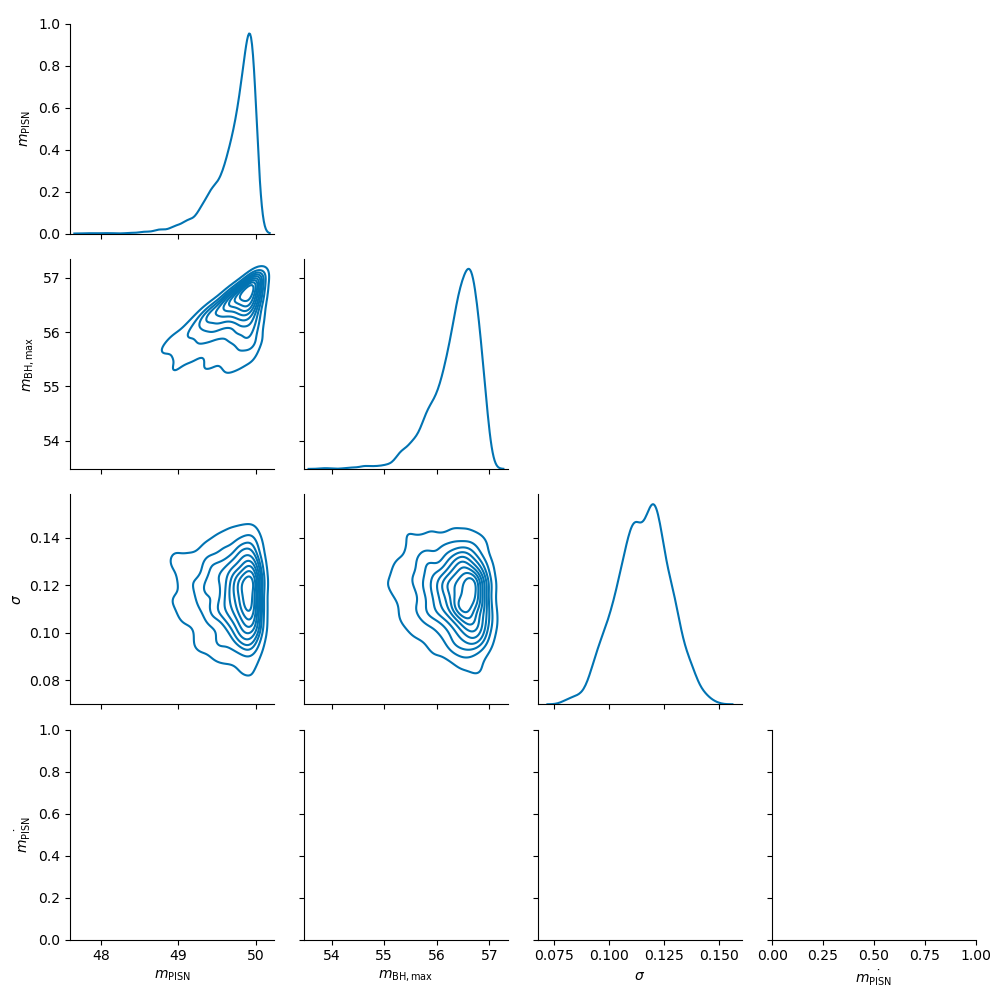

In [33]:
sns.set_palette('colorblind')
#trace = az.from_netcdf(op.join(paths.data, 'trace.nc'))

axes_labels = {
    'mpisn': r'$m_\mathrm{PISN}$',
    'mbhmax': r'$m_\mathrm{BH,max}$',
    'sigma': r'$\sigma$',
    'mpisndot' : r'$\dot{m_\mathrm{PISN}}$'
}
df = pd.DataFrame({axes_labels[k]: gc_818.posterior[k].values.flatten() for k in axes_labels.keys()})

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    pg.axes[i, j].set_visible(False)


pg.add_legend(loc='upper center')

plt.tight_layout()
#plt.title('tight prior')
#plt.savefig(op.join(paths.figures, 'shape_corner.pdf'))

array([[<Axes: title={'center': 'dmbhmax'}>,
        <Axes: title={'center': 'dmbhmax'}>]], dtype=object)

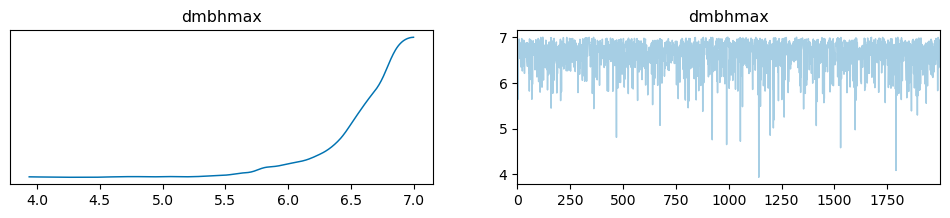

In [34]:
az.plot_trace(gc_818, var_names=['dmbhmax'])

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

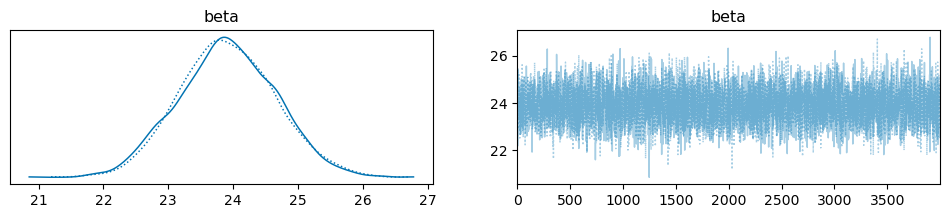

In [22]:
az.plot_trace(gc_818, var_names=['beta'])

### With just one detecotr, lower SNR cutoff

In [12]:
nsamp = 300  # number of posterior draws per event

prior = get_priors_from_file("priors/gwtc3_evolution.prior")
pe_samples = pd.read_hdf('../src/pe_samp_mock1det.hdf5', 'samples')
pe_samples['pdraw_cosmo'] = pe_samples['pdraw']

sel_samples = pd.read_hdf('../src/data/mock_sel_samp1det.h5', 'samples')
sel_samples['pdraw_cosmo'] = sel_samples['pdraw_m1sqz'] * sel_samples['dm1sz_dm1ddl']
sel_samples['m1d'] = sel_samples['m1']*(1+sel_samples['z'])
sel_samples['dl'] = Planck18.luminosity_distance(sel_samples['z'].to_numpy()).to(u.Gpc).value

In [14]:
data = np.load("mock_obs_1det_gc.npz")
print(data.files)
gc_903=process_samples(data)

['Om', 'R', 'R_unit', 'a', 'b', 'beta', 'c', 'dNdVdt_fixed_mq', 'dNdqdVdt_fixed_mz', 'delta_m', 'dkappa', 'dmbhmax', 'h', 'hz', 'lam', 'log_fpl', 'loglik_array_dim', 'mbh_min', 'mdNdmdVdt_fixed_qz', 'mpisn', 'mpisndot', 'neff', 'neff_sel', 'sigma', 'w', 'zmax', 'zp']


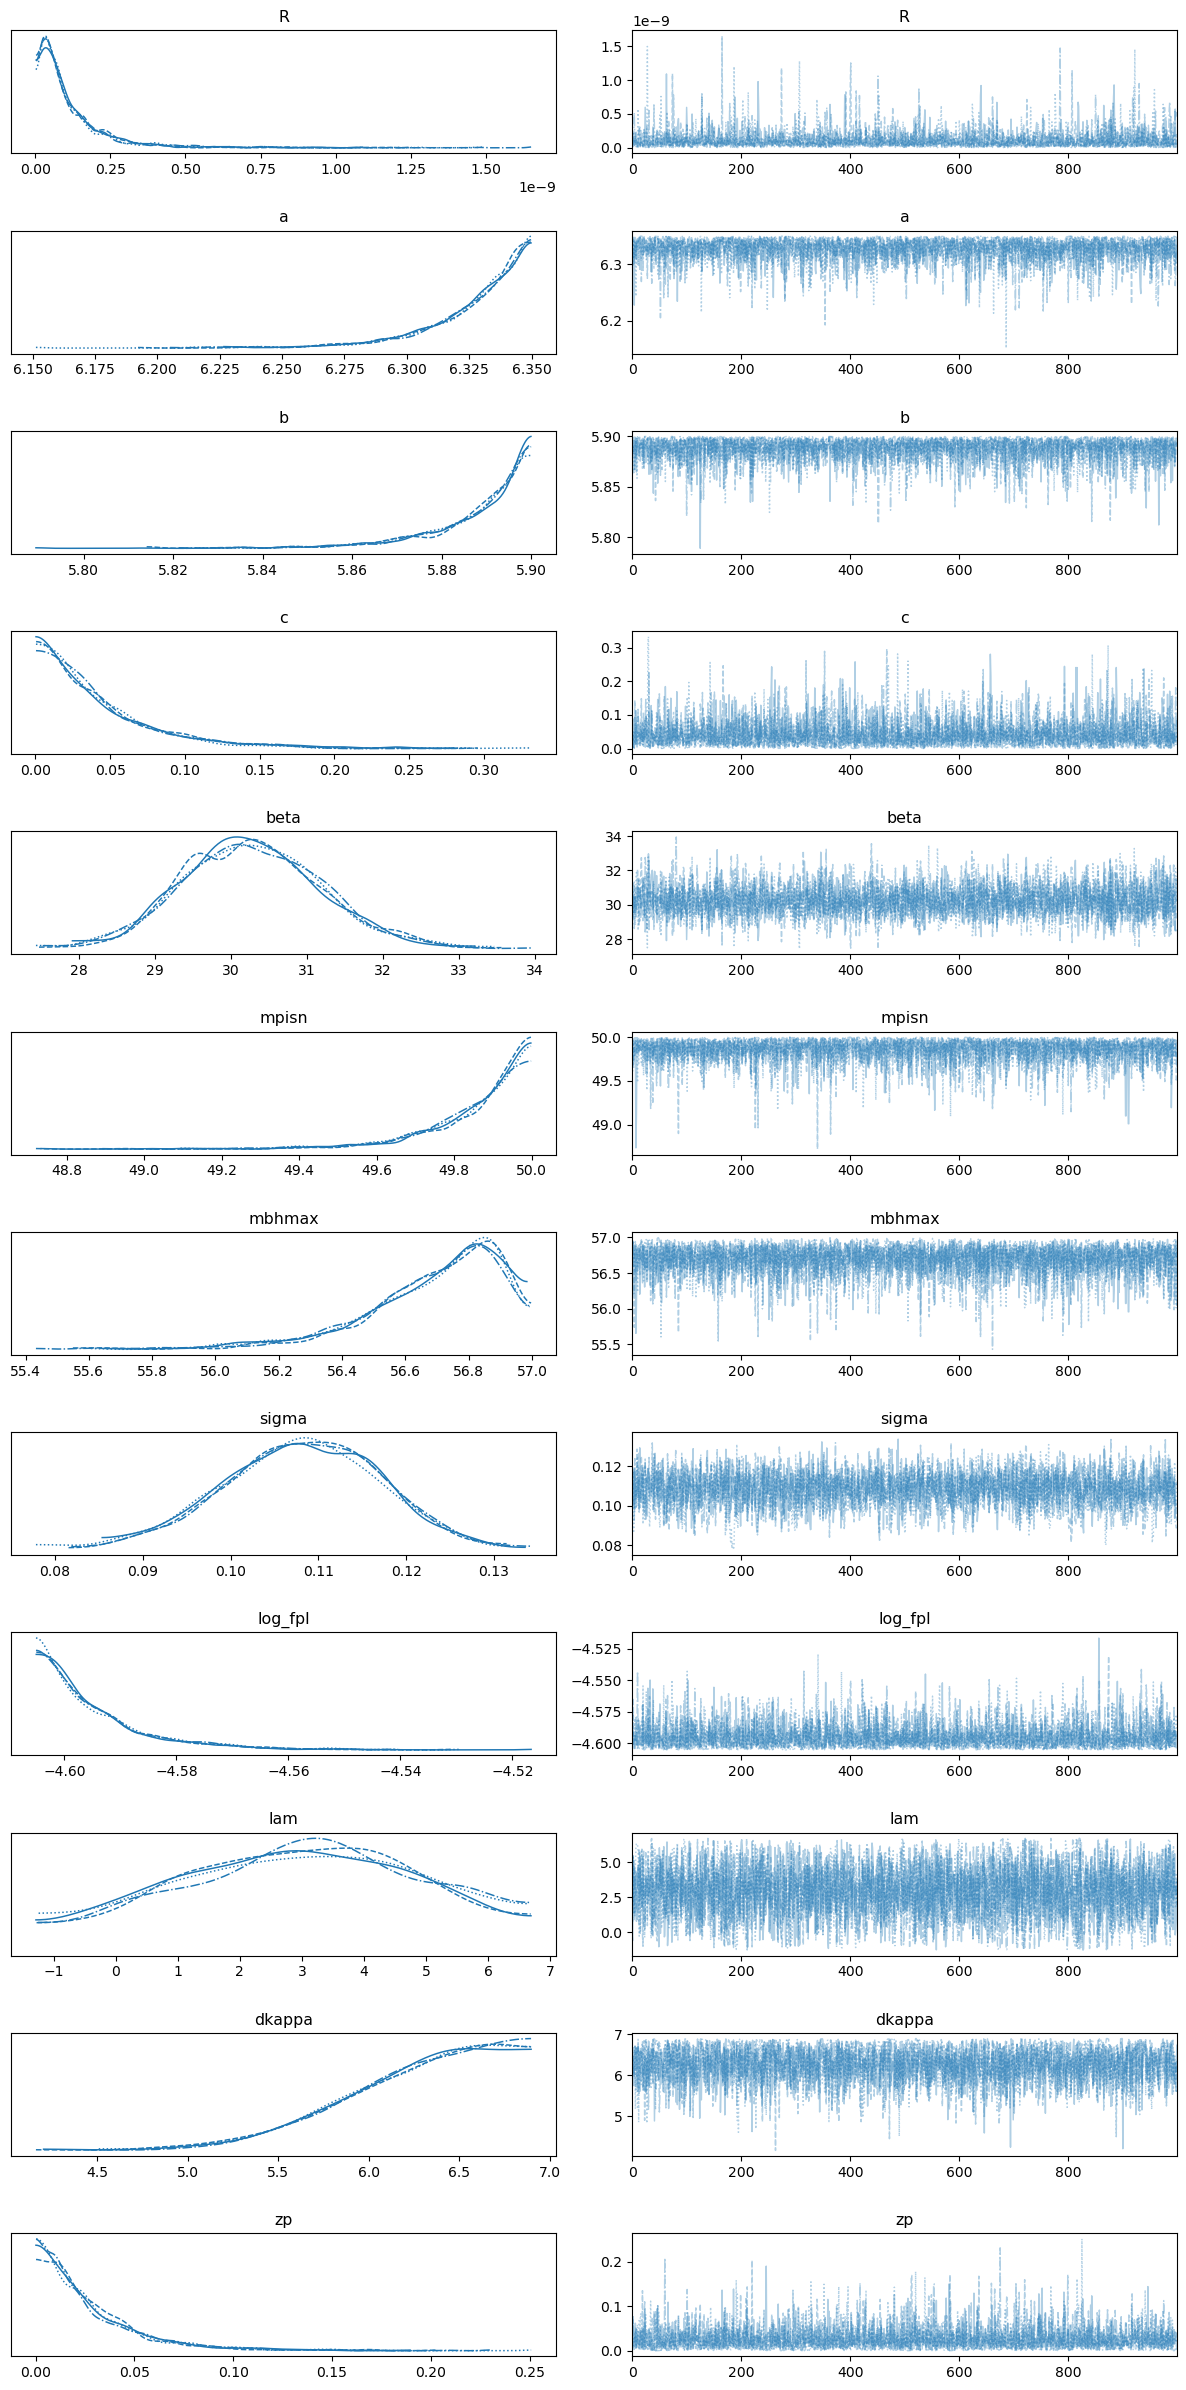

In [15]:
az.plot_trace(gc_903, var_names=['R', 'a', 'b', 'c', 'beta', 'mpisn', 'mbhmax', 'sigma', 'log_fpl', 'lam', 'dkappa', 'zp']);
plt.tight_layout()


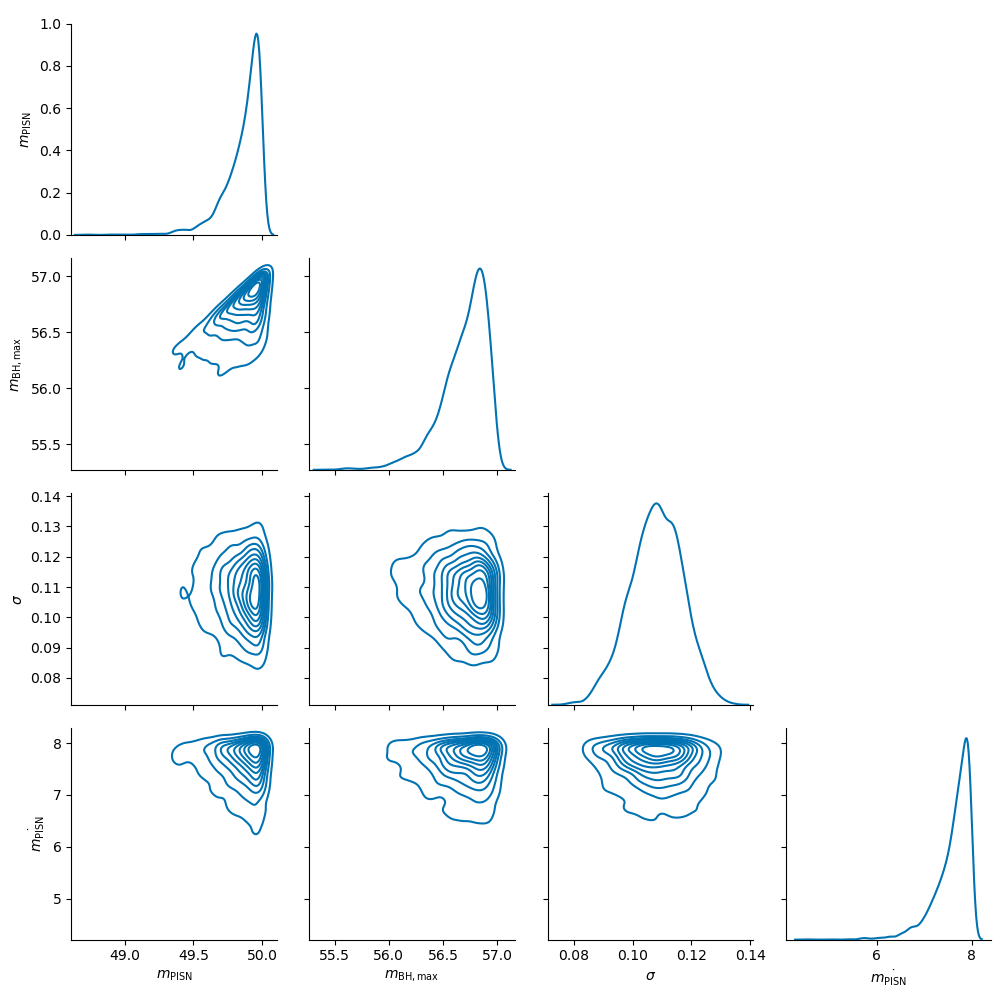

In [18]:
sns.set_palette('colorblind')
#trace = az.from_netcdf(op.join(paths.data, 'trace.nc'))

axes_labels = {
    'mpisn': r'$m_\mathrm{PISN}$',
    'mbhmax': r'$m_\mathrm{BH,max}$',
    'sigma': r'$\sigma$',
    'mpisndot' : r'$\dot{m_\mathrm{PISN}}$'
}
df = pd.DataFrame({axes_labels[k]: gc_903.posterior[k].values.flatten() for k in axes_labels.keys()})

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    pg.axes[i, j].set_visible(False)


pg.add_legend(loc='upper center')

plt.tight_layout()
#plt.title('tight prior')
#plt.savefig(op.join(paths.figures, 'shape_corner.pdf'))